In [1]:
# Load Libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
import ds_functions as ds
from sklearn.model_selection import KFold, cross_val_score

In [2]:
def rand_forest_analysis(X, y, n_holdouts):

    n_estimators = [5, 10, 25, 50, 75, 100, 150, 200, 250, 300]
    max_depths = [5, 10, 25]
    max_features = [.1, .3, .5, .7, .9, 1]
    best_rand_forest = ('', 0, 0)
    last_best_rf = 0
    best_rf = None

    cols = len(max_depths)
    plt.figure()
    fig, axs = plt.subplots(1, cols, figsize=(cols*ds.HEIGHT, ds.HEIGHT), squeeze=False)
    for k in range(len(max_depths)):
        d = max_depths[k]
        values = {}
        for f in max_features:
            yvalues = []
            for n in n_estimators:

                total_acc = 0

                for h in range(n_holdouts):
                    trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)

                    rf = RandomForestClassifier(n_estimators=n, max_depth=d, max_features=f)
                    rf.fit(trnX, trnY)
                    prdY = rf.predict(tstX)
                    total_acc += metrics.accuracy_score(tstY, prdY)

                total_acc /= n_holdouts
                yvalues.append(total_acc)
                if yvalues[-1] > last_best_rf:
                    best_rand_forest = (d, f, n)
                    last_best_rf = yvalues[-1]
                    best_rf = rf

            values[f] = yvalues
        ds.multiple_line_chart(n_estimators, values, ax=axs[0, k], title='Random Forests with max_depth=%d'%d,
                               xlabel='nr estimators', ylabel='accuracy', percentage=True)

    plt.show()
    print('Best results with depth=%d, %1.2f features and %d estimators, with accuracy=%1.2f'%(best_rand_forest[0], best_rand_forest[1], best_rand_forest[2], last_best_rf))
    
    return best_rand_forest

In [3]:
def extremely_random_trees_analysis(X, y, n_holdouts):
    
    n_estimators = [5, 10, 25, 50, 75, 100, 150, 200, 250, 300]
    max_depths = [5, 10, 25]
    max_features = [.1, .3, .5, .7, .9, 1]

    best_extr_tree = ('', 0, 0)
    last_best_xt = 0
    best_xt = None

    cols = len(max_depths)
    plt.figure()
    fig, axs = plt.subplots(1, cols, figsize=(cols*ds.HEIGHT, ds.HEIGHT), squeeze=False)
    for k in range(len(max_depths)):
        d = max_depths[k]
        values = {}
        for f in max_features:
            yvalues = []
            for n in n_estimators:

                total_acc = 0

                for h in range(n_holdouts):
                    trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)

                    rf = ExtraTreesClassifier(n_estimators=n, max_depth=d, max_features=f)
                    rf.fit(trnX, trnY)
                    prdY = rf.predict(tstX)
                    total_acc += metrics.accuracy_score(tstY, prdY)

                total_acc /= n_holdouts
                yvalues.append(total_acc)
                if yvalues[-1] > last_best_xt:
                    best_extr_tree = (d, f, n)
                    last_best_xt = yvalues[-1]
                    best_xt = rf

            values[f] = yvalues
        ds.multiple_line_chart(n_estimators, values, ax=axs[0, k], title='Extremely Randomized Trees with max_depth=%d'%d,
                               xlabel='nr estimators', ylabel='accuracy', percentage=True)

    plt.show()
    print('Best results with depth=%d, %1.2f features and %d estimators, with accuracy=%1.2f'%(best_extr_tree[0], best_extr_tree[1], best_extr_tree[2], last_best_xt))
    
    return best_extr_tree

In [4]:
def evaluate_rand_forest(best_rand_forest, n_holdouts=10):
    # Compute Average Metrics for Best Random Forest vs. Best Extremely Random Trees

    acc = [0, 0]
    recall = [0, 0]
    specificity = [0, 0]
    precision = [0, 0]
    matrices = np.zeros((2, 2, n_holdouts))

    for h in range(n_holdouts):
        trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)

        rf = RandomForestClassifier(n_estimators=best_rand_forest[2], max_depth=best_rand_forest[0], max_features=best_rand_forest[1])
        rf.fit(trnX, trnY)

        prd_trn = rf.predict(trnX)
        prd_tst = rf.predict(tstX)

        cnf_mtx_trn = metrics.confusion_matrix(trnY, prd_trn, labels)
        tn_trn, fp_trn, fn_trn, tp_trn = cnf_mtx_trn.ravel()
        cnf_mtx_tst = metrics.confusion_matrix(tstY, prd_tst, labels)
        matrices[:,:,h] = cnf_mtx_tst
        tn_tst, fp_tst, fn_tst, tp_tst = cnf_mtx_tst.ravel()

        acc[0] += (tn_trn + tp_trn) / (tn_trn + tp_trn + fp_trn + fn_trn)
        acc[1] += (tn_tst + tp_tst) / (tn_tst + tp_tst + fp_tst + fn_tst)

        recall[0] += tp_trn / (tp_trn + fn_trn)
        recall[1] += tp_tst / (tp_tst + fn_tst)

        specificity[0] += tn_trn / (tn_trn + fp_trn)
        specificity[1] += tn_tst / (tn_tst + fp_tst)

        precision[0] += tp_trn / (tp_trn + fp_trn)
        precision[1] += tp_tst / (tp_tst + fp_tst)


    acc = np.divide(acc, n_holdouts)
    recall = np.divide(recall, n_holdouts)
    specificity = np.divide(specificity, n_holdouts)
    precision = np.divide(precision, n_holdouts)
    cnf_mtx_rt = np.mean(matrices, axis=2).astype('int64')

    evaluation_rt = {'Accuracy': acc,
                  'Recall': recall,
                  'Specificity': specificity,
                  'Precision': precision}
    
    return evaluation_rt, cnf_mtx_rt

In [5]:
def evaluation_extra_trees(best_extr_tree, n_holdouts=10):
    acc = [0, 0]
    recall = [0, 0]
    specificity = [0, 0]
    precision = [0, 0]
    matrices = np.zeros((2, 2, n_holdouts))

    for h in range(n_holdouts):
        trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)

        rf = ExtraTreesClassifier(n_estimators=best_extr_tree[2], max_depth=best_extr_tree[0], max_features=best_extr_tree[1])
        rf.fit(trnX, trnY)

        prd_trn = rf.predict(trnX)
        prd_tst = rf.predict(tstX)

        cnf_mtx_trn = metrics.confusion_matrix(trnY, prd_trn, labels)
        tn_trn, fp_trn, fn_trn, tp_trn = cnf_mtx_trn.ravel()
        cnf_mtx_tst = metrics.confusion_matrix(tstY, prd_tst, labels)
        matrices[:,:,h] = cnf_mtx_tst
        tn_tst, fp_tst, fn_tst, tp_tst = cnf_mtx_tst.ravel()

        acc[0] += (tn_trn + tp_trn) / (tn_trn + tp_trn + fp_trn + fn_trn)
        acc[1] += (tn_tst + tp_tst) / (tn_tst + tp_tst + fp_tst + fn_tst)

        recall[0] += tp_trn / (tp_trn + fn_trn)
        recall[1] += tp_tst / (tp_tst + fn_tst)

        specificity[0] += tn_trn / (tn_trn + fp_trn)
        specificity[1] += tn_tst / (tn_tst + fp_tst)

        precision[0] += tp_trn / (tp_trn + fp_trn)
        precision[1] += tp_tst / (tp_tst + fp_tst)


    acc = np.divide(acc, n_holdouts)
    recall = np.divide(recall, n_holdouts)
    specificity = np.divide(specificity, n_holdouts)
    precision = np.divide(precision, n_holdouts)
    cnf_mtx = np.mean(matrices, axis=2).astype('int64')

    evaluation = {'Accuracy': acc,
                  'Recall': recall,
                  'Specificity': specificity,
                  'Precision': precision}
    
    return evaluation, cnf_mtx


 ORAL_reduced30_extraTreeClassifier


<Figure size 600x450 with 0 Axes>

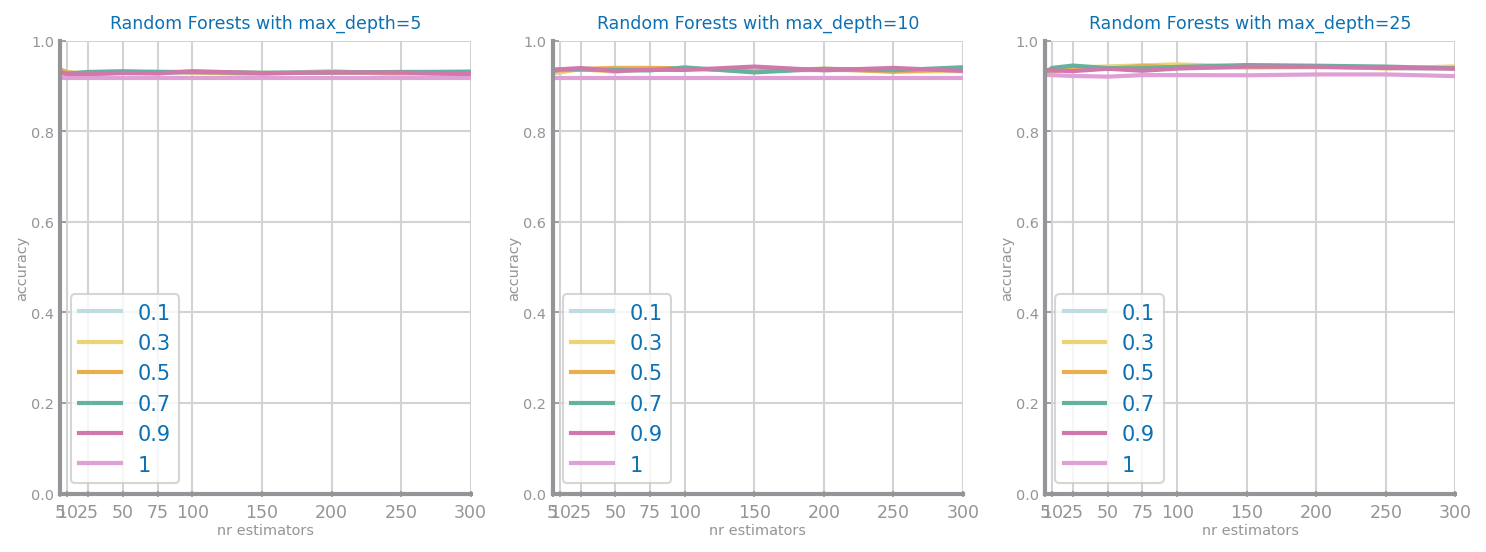

Best results with depth=25, 0.30 features and 100 estimators, with accuracy=0.95


<Figure size 600x450 with 0 Axes>

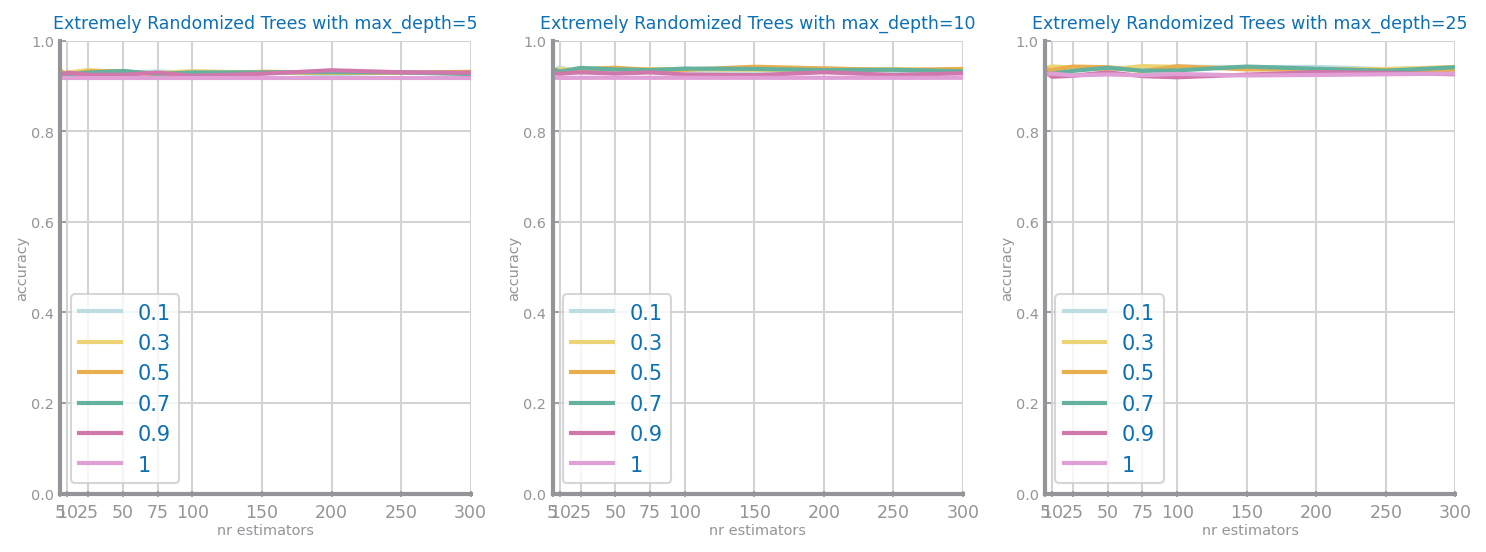

Best results with depth=25, 0.30 features and 75 estimators, with accuracy=0.94
Random Forests:
 {'Accuracy': array([1.  , 0.94]), 'Recall': array([0.96, 0.42]), 'Specificity': array([1.  , 0.99]), 'Precision': array([1.  , 0.74])}

Extremely Random Trees:
 {'Accuracy': array([1.  , 0.94]), 'Recall': array([0.98, 0.47]), 'Specificity': array([1.  , 0.98]), 'Precision': array([1.  , 0.69])}


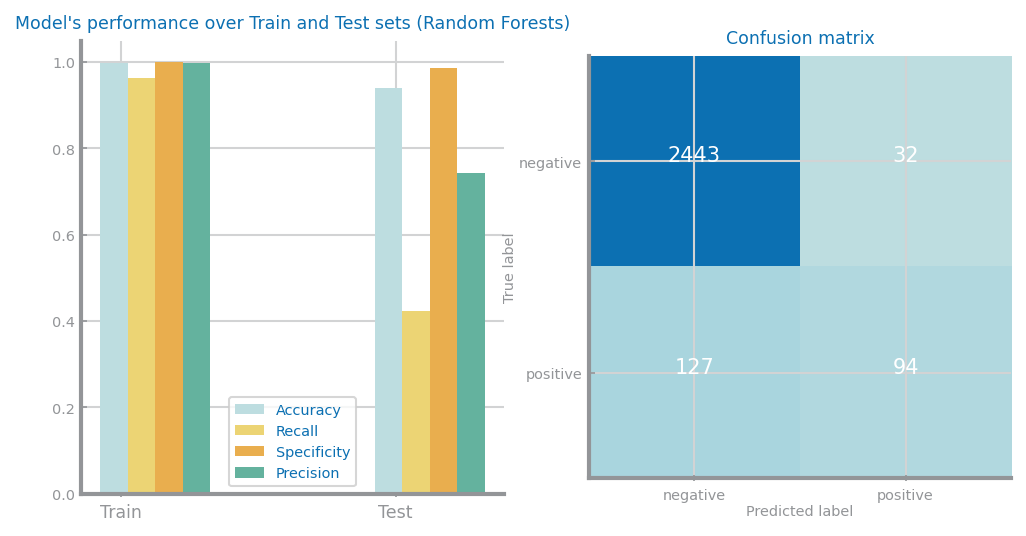

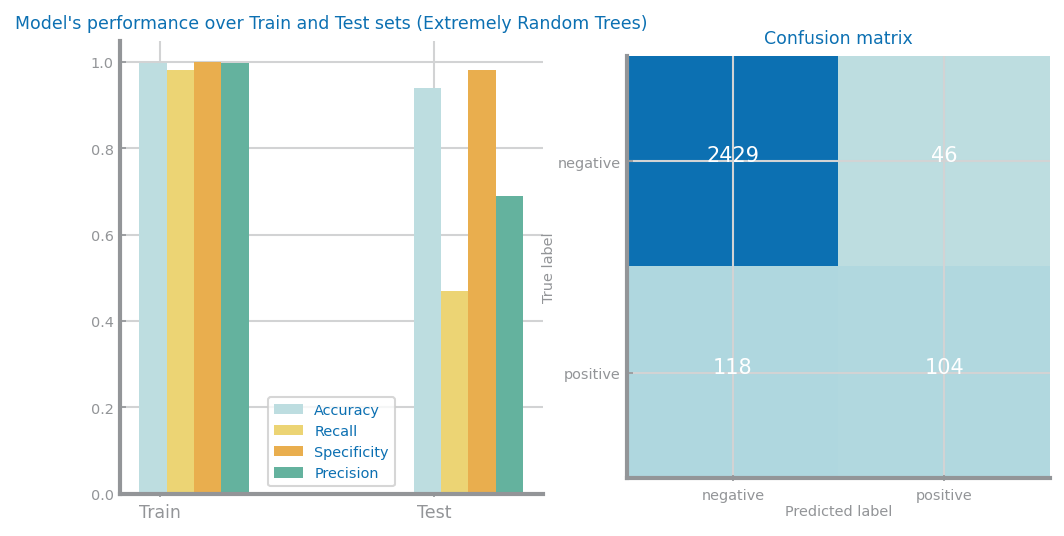








 ORAL_reduced32_chi


<Figure size 600x450 with 0 Axes>

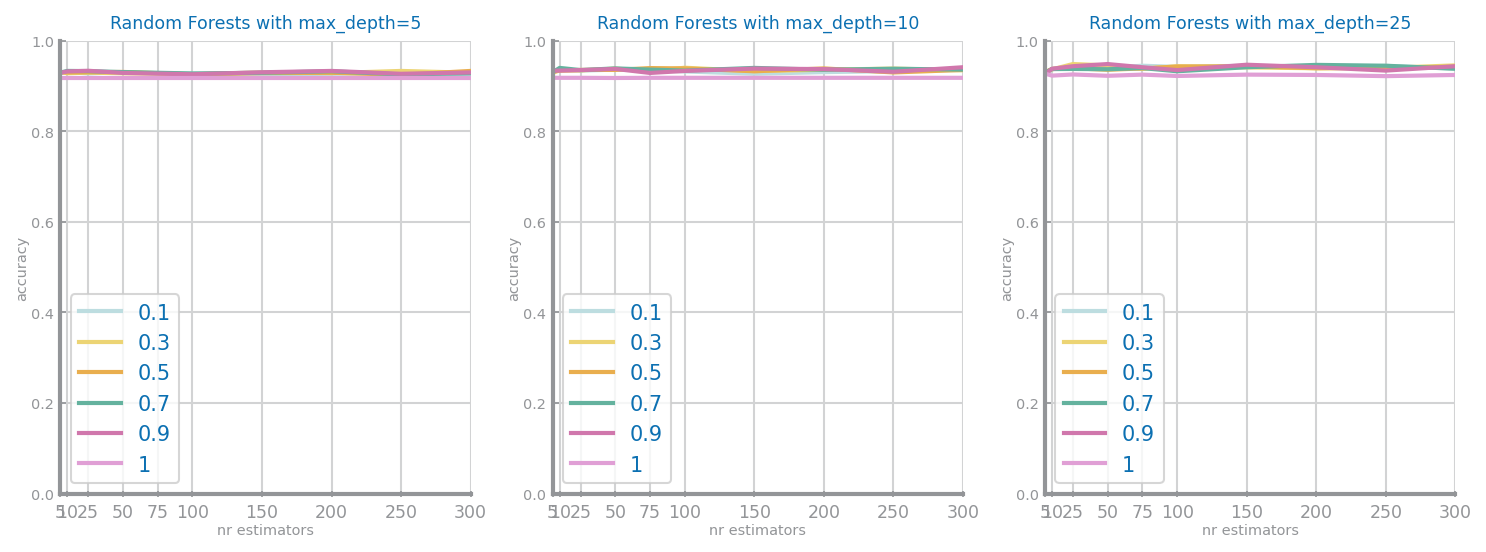

Best results with depth=25, 0.30 features and 25 estimators, with accuracy=0.95


<Figure size 600x450 with 0 Axes>

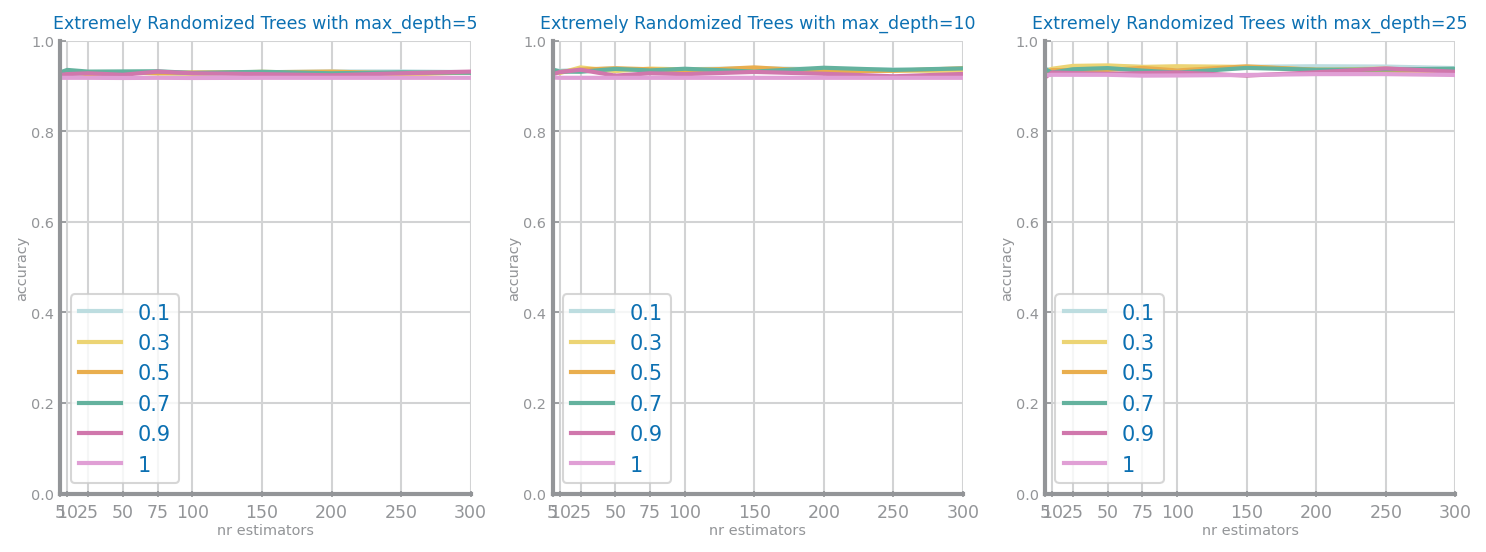

Best results with depth=25, 0.30 features and 50 estimators, with accuracy=0.95
Random Forests:
 {'Accuracy': array([0.99, 0.94]), 'Recall': array([0.94, 0.43]), 'Specificity': array([1.  , 0.99]), 'Precision': array([1.  , 0.75])}

Extremely Random Trees:
 {'Accuracy': array([1.  , 0.94]), 'Recall': array([0.98, 0.46]), 'Specificity': array([1.  , 0.98]), 'Precision': array([1. , 0.7])}


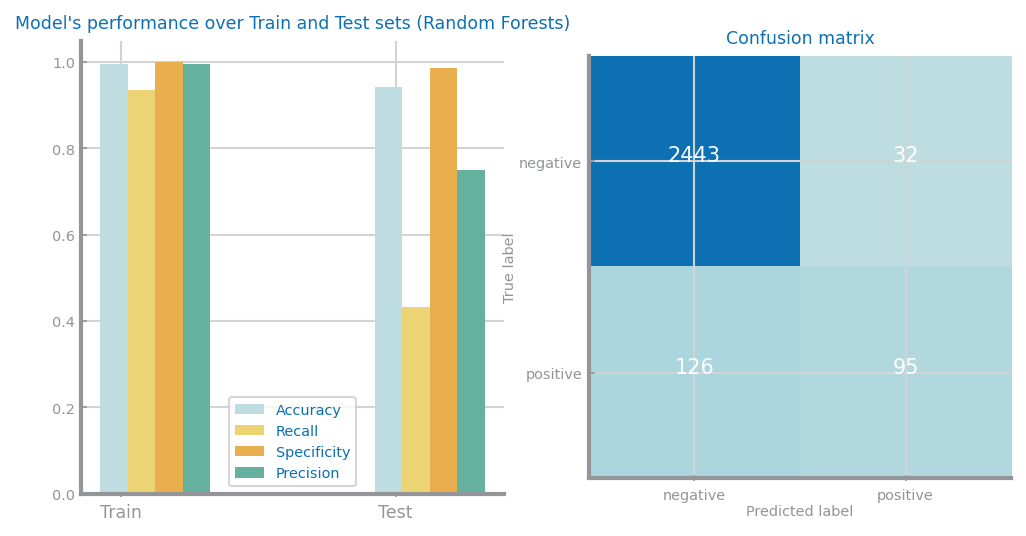

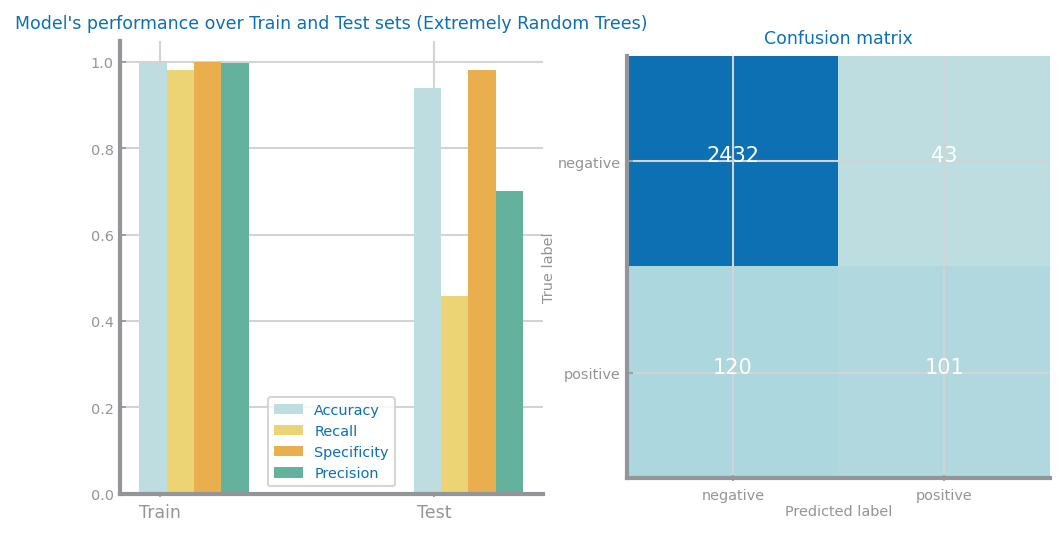








 ORAL_reduced32_mutual


KeyboardInterrupt: 

<Figure size 600x450 with 0 Axes>

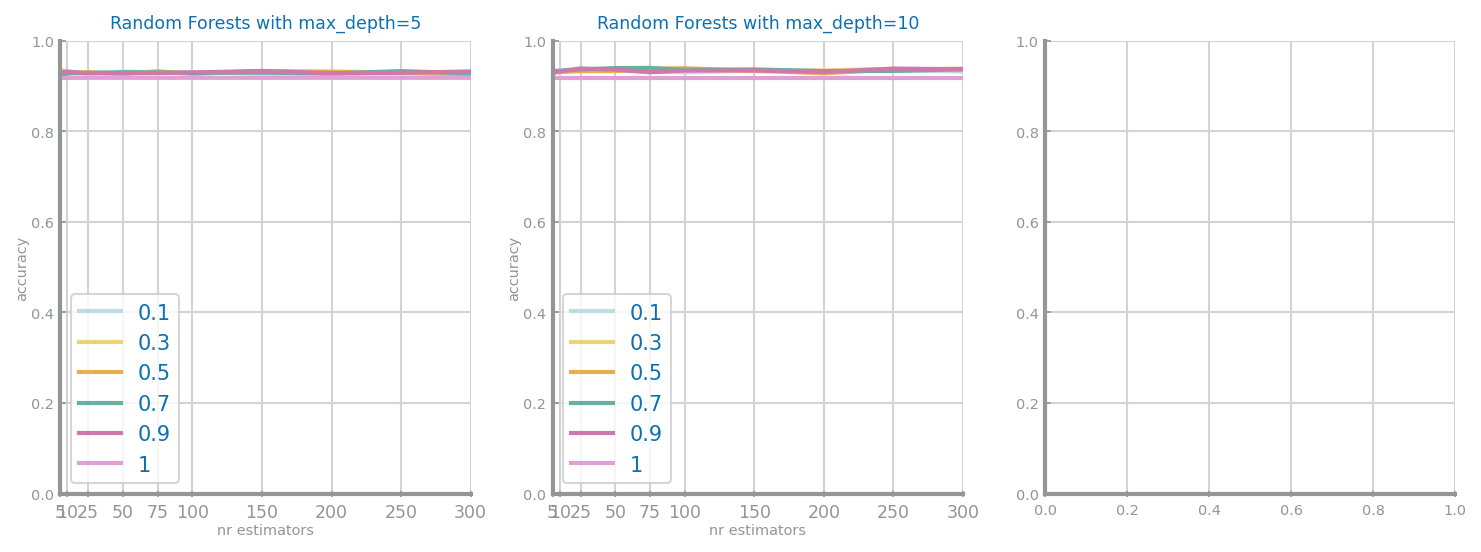

In [6]:
import os

directory = '../../datasets/TO_TEST/ORAL/reduced'

overall_accs = []
datasets = []
    
for filename in os.listdir(directory):
    if filename.endswith(".csv"): 
        path = directory + '/' + filename
        print('\n', filename.split('.')[0])
        data: pd.DataFrame = pd.read_csv('../../datasets/qsar_oral_toxicity.csv', sep=';', header=None)    
        y: np.ndarray = data.pop(data.shape[1] - 1).values # Target Variable
        X: np.ndarray = data.values # Values of each feature on each record
        labels = pd.unique(y)

        # Perform RandomForest analysis and display results
        best_rf = rand_forest_analysis(X, y, n_holdouts=1)
        
        # Perform ExtremelyRandomTrees analysis and display results
        best_er = extremely_random_trees_analysis(X, y, n_holdouts=1)
        
        # Evaluate the best random forest
        evaluation_rt, cnf_mtx_rt = evaluate_rand_forest(best_rf)
        
        # Evaluate the best extremely random trees
        evaluation, cnf_mtx = evaluation_extra_trees(best_er)
        
        fig, axs = plt.subplots(1, 2, figsize=(2 * ds.HEIGHT, ds.HEIGHT))
        ds.multiple_bar_chart(['Train', 'Test'], evaluation_rt, ax=axs[0], title="Model's performance over Train and Test sets (Random Forests)")
        ds.plot_confusion_matrix(cnf_mtx_rt, labels, ax=axs[1])

        print("Random Forests:\n", evaluation_rt)

        fig, axs = plt.subplots(1, 2, figsize=(2 * ds.HEIGHT, ds.HEIGHT))
        ds.multiple_bar_chart(['Train', 'Test'], evaluation, ax=axs[0], title="Model's performance over Train and Test sets (Extremely Random Trees)")
        ds.plot_confusion_matrix(cnf_mtx, labels, ax=axs[1])

        print("\nExtremely Random Trees:\n", evaluation)
        
        plt.show()
        
        # Record the Maximum accuracy achieved
        max_acc = max(evaluation_rt['Accuracy'][1], evaluation['Accuracy'][1])
        overall_accs += [max_acc]
        
        # Dataset name
        datasets += [filename.split('.')[0]]

        
        print('\n\n\n\n\n')

In [ ]:
accs = pd.Series(overall_accs)

# Plot the figure.
plt.figure(figsize=(12, 8))
ax = accs.plot(kind='bar')
ax.set_title('Max Accuracy by Dataset (between the tested models)')
ax.set_xlabel('Dataset')
ax.set_ylabel('Accuracy')
ax.set_xticklabels(datasets)